In [7]:
!pip install --upgrade accelerate peft transformers trl bitsandbytes

In [8]:
import os
os.environ["CUDA_VERSION"] = "124"

In [9]:
!python -m bitsandbytes

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++ BUG REPORT INFORMATION ++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++ OTHER +++++++++++++++++++++++++++
CUDA specs: CUDASpecs(highest_compute_capability=(6, 0), cuda_version_string='121', cuda_version_tuple=(12, 1))
PyTorch settings found: CUDA_VERSION=121, Highest Compute Capability: (6, 0).
To manually override the PyTorch CUDA version please see: https://github.com/TimDettmers/bitsandbytes/blob/main/docs/source/nonpytorchcuda.mdx
If you run into issues with 8-bit matmul, you can try 4-bit quantization:
https://huggingface.co/blog/4bit-transformers-bitsandbytes
CUDA SETUP: WARNING! CUDA runtime files not found in any environmental path.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++ DEBUG INFO END ++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Checking that the library is i

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
!pip install -q transformers huggingface_hub
import torch.nn.functional as F
from huggingface_hub import login

# Paste your Hugging Face Access Token (Get it from https://huggingface.co/settings/tokens)
login("hf_key")


**Load meta-llama/Llama-3.2-3B-Instruct with QLoRA (4-bit Quantization)**

In [5]:
from peft import prepare_model_for_kbit_training

model_name= "meta-llama/Llama-3.2-3B-Instruct"

# Enable 4-bit quantization using bitsandbytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load the model in 4-bit mode
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    offload_folder="offload"
)

# Configure LoRA adapters
peft_config = LoraConfig(
    r=64,  # LoRA rank
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="CAUSAL_LM",
)

# Wrap model with PEFT
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model = prepare_model_for_kbit_training(model)
model.config.use_cache = False
model.config.pretraining_tp = 1
print(model.hf_device_map) 
print(next(model.parameters()).device)

# ✅ Save the quantized model
quantized_model_path = "/kaggle/working/quantized_model"
model.save_pretrained(quantized_model_path)

print(f"✅ Quantized model saved at: {quantized_model_path}")

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

trainable params: 18,350,080 || all params: 3,231,099,904 || trainable%: 0.5679
{'': 0}
cuda:0
✅ Quantized model saved at: /kaggle/working/quantized_model


 **Load Dataset and Tokenize the Dataset**

In [6]:
import torch
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

# Clear GPU cache
torch.cuda.empty_cache()
import gc

# Load a subset of the dataset
dataset_name = "HumanLLMs/Human-Like-DPO-Dataset"
dataset = load_dataset(dataset_name, split="train").select(range(1000))  # Limit to 1000 samples

# Type Check & Convert to Torch Format
dataset.set_format(type="torch")

# ---- STEP 3: Tokenize & Preprocess Dataset ----
tokenizer = AutoTokenizer.from_pretrained(model_name)  # ✅ Define tokenizer
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as padding

MAX_LENGTH = 256  # Try lowering this if OOM persists

def preprocess_function(example):
    return {
        "input_ids_prompt": tokenizer(example["prompt"], padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")["input_ids"].squeeze(0),
        "input_ids_chosen": tokenizer(example["chosen"], padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")["input_ids"].squeeze(0),
        "input_ids_rejected": tokenizer(example["rejected"], padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")["input_ids"].squeeze(0),
    }

dataset = dataset.map(preprocess_function)
dataset.set_format(type="torch")

# ---- STEP 4: Create DataLoader ----
def collate_fn(batch):
    return {
        "input_ids_prompt": torch.stack([b["input_ids_prompt"] for b in batch]),
        "input_ids_chosen": torch.stack([b["input_ids_chosen"] for b in batch]),
        "input_ids_rejected": torch.stack([b["input_ids_rejected"] for b in batch]),
    }

train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
torch.cuda.empty_cache()
gc.collect()

README.md:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

data.json:   0%|          | 0.00/28.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10884 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

120

collate_fn is a function that groups multiple samples together into a batch.
Since different samples can have different lengths, we use collate_fn to stack them correctly.
Example Without collate_fn

If you try to batch tokenized sentences without proper formatting, you'll get an error because they might have different shapes.

The DataLoader in PyTorch handles batching, shuffling, and parallel loading of the dataset during training. Instead of loading the entire dataset into memory at once, it efficiently loads mini-batches for training.

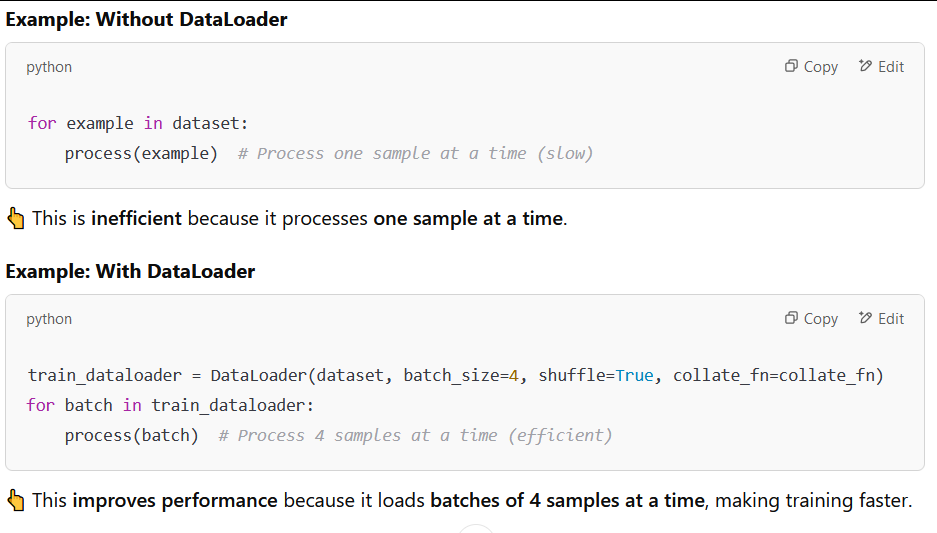
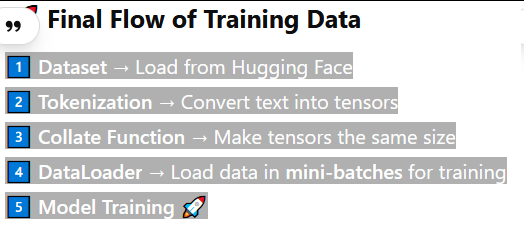

**Fine-Tuning with QLoRA**

In [10]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler


# Check if GPU is available, otherwise fallback to CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)  # Should print "cuda" if GPU is available

# ---- STEP 5: Define Contrastive Loss ----
def contrastive_loss(model, batch):
    # Get embeddings
    prompt_embeds = model.get_input_embeddings()(batch["input_ids_prompt"].to(DEVICE))
    chosen_embeds = model.get_input_embeddings()(batch["input_ids_chosen"].to(DEVICE))
    rejected_embeds = model.get_input_embeddings()(batch["input_ids_rejected"].to(DEVICE))

    # Compute Mean Pooled Embeddings
    prompt_mean = prompt_embeds.mean(dim=1)
    chosen_mean = chosen_embeds.mean(dim=1)
    rejected_mean = rejected_embeds.mean(dim=1)

    # Cosine Similarity
    pos_sim = F.cosine_similarity(prompt_mean, chosen_mean, dim=-1)
    neg_sim = F.cosine_similarity(prompt_mean, rejected_mean, dim=-1)

    # Loss = Maximize pos_sim and Minimize neg_sim
    loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim)))
    return loss.mean()

Using device: cuda


**Train, Merge and Save Fine-Tuned Model**

In [18]:
import torch
import gc
from torch.amp import autocast, GradScaler

# ---- Memory Optimization ----
torch.cuda.empty_cache()
gc.collect()

# ---- Disable Cache to Save Memory ----
model.config.use_cache = False
model.gradient_checkpointing_enable()  # Saves memory by recomputing activations

# ---- Mixed Precision Training ----
scaler = GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# ---- Gradient Accumulation ----
grad_accum_steps = 4  # Simulate larger batch

for epoch in range(1):  # Run for 1 epoch
    model.train()
    optimizer.zero_grad()

    for step, batch in enumerate(train_dataloader):
        with autocast("cuda"):  # Enable mixed precision
            loss = contrastive_loss(model, batch) / grad_accum_steps  # Normalize loss

        scaler.scale(loss).backward()

        if (step + 1) % grad_accum_steps == 0:  # Only step optimizer after accumulation
            # 🔹 Check if gradients exist before unscale & optimizer step
            if any(param.grad is not None for param in model.parameters()):
                scaler.unscale_(optimizer)  # Ensure valid gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            else:
                print(f"❌ No gradients found at step {step}, skipping optimizer step.")
                optimizer.zero_grad()  # Reset even if no gradients

        # ---- Free GPU Memory More Frequently ----
        if (step + 1) % 5 == 0:  
            torch.cuda.empty_cache()
            gc.collect()

    # ---- Save Intermediate Model ----
    model.save_pretrained(f"intermediate_model_epoch_{epoch+1}")
    tokenizer.save_pretrained(f"intermediate_model_epoch_{epoch+1}")

# ---- Merge LoRA Adapters ----
model = model.merge_and_unload()

# ---- Save Final Model ----
model.save_pretrained("final_model")
tokenizer.save_pretrained("final_model")

# ---- Debug: Print GPU Memory Usage ----
print(torch.cuda.memory_summary())


❌ No gradients found at step 3, skipping optimizer step.
❌ No gradients found at step 7, skipping optimizer step.
❌ No gradients found at step 11, skipping optimizer step.
❌ No gradients found at step 15, skipping optimizer step.
❌ No gradients found at step 19, skipping optimizer step.
❌ No gradients found at step 23, skipping optimizer step.
❌ No gradients found at step 27, skipping optimizer step.
❌ No gradients found at step 31, skipping optimizer step.
❌ No gradients found at step 35, skipping optimizer step.
❌ No gradients found at step 39, skipping optimizer step.
❌ No gradients found at step 43, skipping optimizer step.
❌ No gradients found at step 47, skipping optimizer step.
❌ No gradients found at step 51, skipping optimizer step.
❌ No gradients found at step 55, skipping optimizer step.
❌ No gradients found at step 59, skipping optimizer step.
❌ No gradients found at step 63, skipping optimizer step.
❌ No gradients found at step 67, skipping optimizer step.
❌ No gradients f

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   3175 MiB |   3726 MiB |  34733 MiB |  31558 MiB |
|       from large pool |   3056 MiB |   3613 MiB |  34004 MiB |  30948 MiB |
|       from small pool |    118 MiB |    119 MiB |    729 MiB |    610 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   3175 MiB |   3726 MiB |  34733 MiB |  31558 MiB |
|       from large pool |   3056 MiB |   3613 MiB |  34004 MiB |

**Test the Model**

In [21]:
inputs = tokenizer("HOW WAS YOUR DAY?", return_tensors="pt").to(DEVICE)
output = model.generate(**inputs, max_length=100)
print(tokenizer.decode(output[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


HOW WAS YOUR DAY? (May 24, 2021)

I hope you had a great day! I had a fantastic day, thanks for asking! I got to spend time with loved ones, and I even managed to squeeze in a few hours of work. It was a productive day, and I'm feeling quite accomplished.

But I have to say, I'm a bit curious - how was your day? Did you do anything exciting or just relax and unwind? I'm all ears
